In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from system_ode_fedbatch import generate_data
from machinelearning_control_fedbatch import main, generate_dataset

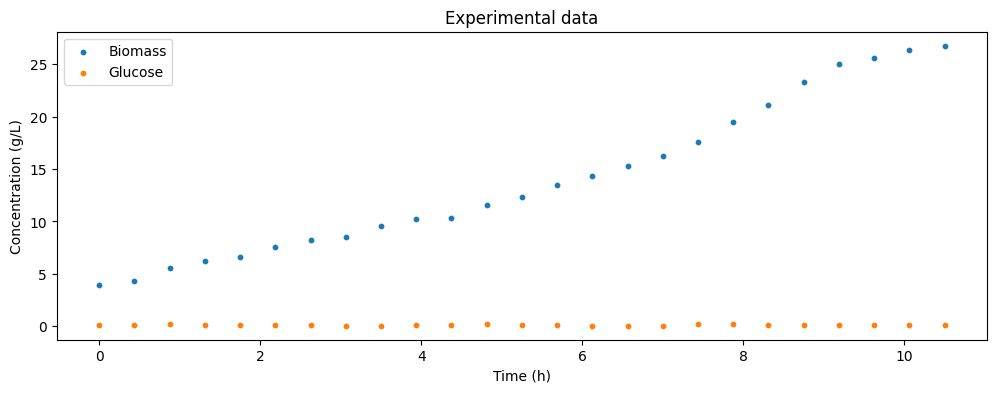

In [22]:
full_df = generate_data()

plt.figure(figsize=(12, 4))
plt.scatter(full_df['RTime'], full_df['Biomass'], s=10, label='Biomass')
plt.scatter(full_df['RTime'], full_df['Glucose'], s=10, label='Glucose')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/L)')
plt.legend()
plt.title('Experimental data')
plt.show()

In [23]:
in_train, out_train = generate_dataset(full_df)

Dataset shape: (100, 4)


In [24]:
# parameter values
mumax = 0.84     # 1/hour
Ks = 0.2          # g/liter
Yxs = 0.5         # g/g
Sin = 1.43 * 200  # g/liter

# initial conditions
t_start = full_df['RTime'].iloc[0]
t_end = full_df['RTime'].iloc[-1]
V0 = full_df['V'].iloc[0]
S0 = full_df['Glucose'].iloc[0]

In [25]:
net = main(in_train, out_train, t_start, t_end, Sin, V0, S0, mumax, Ks, Yxs)

Epoch 0, Loss_data: 6.7356, Loss_ode: 2.8868
Epoch 100, Loss_data: 1.5055, Loss_ode: 0.6321
Epoch 200, Loss_data: 0.0044, Loss_ode: 0.3542
Epoch 300, Loss_data: 0.0038, Loss_ode: 0.2404
Epoch 400, Loss_data: 0.0031, Loss_ode: 0.2390
Epoch 500, Loss_data: 0.0031, Loss_ode: 0.1218
Epoch 600, Loss_data: 0.0018, Loss_ode: 0.1415
Epoch 700, Loss_data: 0.0012, Loss_ode: 0.0661
Epoch 800, Loss_data: 0.0007, Loss_ode: 0.1087
Epoch 900, Loss_data: 0.0004, Loss_ode: 0.0727
Epoch 1000, Loss_data: 0.0004, Loss_ode: 0.0260
Epoch 1100, Loss_data: 0.0004, Loss_ode: 0.0472
Epoch 1200, Loss_data: 0.0004, Loss_ode: 0.0168
Epoch 1300, Loss_data: 0.0004, Loss_ode: 0.0189
Epoch 1400, Loss_data: 0.0004, Loss_ode: 0.0254
Epoch 1500, Loss_data: 0.0004, Loss_ode: 0.0230
Epoch 1600, Loss_data: 0.0006, Loss_ode: 0.0651
Epoch 1700, Loss_data: 0.0004, Loss_ode: 0.0081
Epoch 1800, Loss_data: 0.0006, Loss_ode: 0.0724
Epoch 1900, Loss_data: 0.0004, Loss_ode: 0.0075
Epoch 2000, Loss_data: 0.0004, Loss_ode: 0.0077
Epoc

In [26]:
# pickle save the model
import pickle
with open("pinc_model.pkl", "wb") as f:
    pickle.dump(net, f)

# Autoregression

In [31]:
from machinelearning_control_fedbatch import numpy_to_tensor
import torch
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T_s = full_df['RTime'].iloc[1]
t_test = numpy_to_tensor(np.array([full_df["RTime"].values]))
X_test = numpy_to_tensor(np.array([full_df["Biomass"].values]))
S_test = numpy_to_tensor(np.array([full_df["Glucose"].values]))
u_test = torch.cat([t_test, X_test, S_test], dim=1)
x_test = torch.cat([X_test, S_test], dim=1)

In [32]:
X_0 = X_test[0]
S_0 = S_test[0]

X_preds = []
S_preds = []
for i in range(len(u_test)):
    x_k = net.forward(torch.tensor([T_s, X_0, S_0], dtype=torch.float32).to(DEVICE))
    X_0 = X_test[i]
    S_0 = S_test[i]
    X_preds.append(x_k[0].item())
    S_preds.append(x_k[1].item())

In [33]:
t_test = t_test.detach().cpu().numpy()
X_test = X_test.detach().cpu().numpy()
S_test = S_test.detach().cpu().numpy()

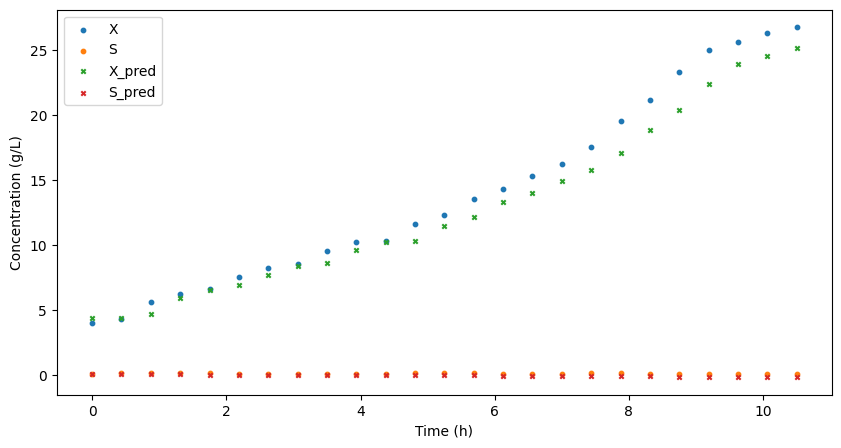

In [38]:
plt.figure(figsize=(10, 5))
plt.scatter(t_test, X_test, s=10, label="X")
plt.scatter(t_test, S_test, s=10, label="S")

plt.scatter(t_test, X_preds, s=10, marker='x', label="X_pred")
plt.scatter(t_test, S_preds, s=10, marker='x', label="S_pred")

plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.show()